#### Sameer Shaik
#### G49843839

In this assignment, you will become familiar with the deep learning library Pytorch through the construction of a feed-forward neural network and a convolutional neural network applied to the MNIST dataset.  In various parts of the notebook, there will be places to fill in.

In [33]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
SEED = 1
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Download and use the MNIST dataset from Homework 1.

In [34]:
dataset_filename = '../data/data_mnist.csv' # fill in
df = pd.read_csv(dataset_filename)
print(df.shape)

(42000, 785)


In [35]:
y = df.iloc[:, 0].to_numpy()  # fill in
X = df.iloc[:, 1:].to_numpy()  #fill in

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [36]:
print(y_test.shape)

(6300,)


In [37]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [38]:
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,output_dim)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [39]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [40]:
fit(mlp, train_loader)

Epoch : 0 [0/35700 (0%)]	Loss: 13.632271	 Accuracy:6.250%
Epoch : 0 [1600/35700 (4%)]	Loss: 0.539928	 Accuracy:64.461%
Epoch : 0 [3200/35700 (9%)]	Loss: 0.353133	 Accuracy:73.731%
Epoch : 0 [4800/35700 (13%)]	Loss: 0.946102	 Accuracy:78.311%
Epoch : 0 [6400/35700 (18%)]	Loss: 0.078643	 Accuracy:81.032%
Epoch : 0 [8000/35700 (22%)]	Loss: 0.617004	 Accuracy:82.719%
Epoch : 0 [9600/35700 (27%)]	Loss: 0.287859	 Accuracy:83.866%
Epoch : 0 [11200/35700 (31%)]	Loss: 0.169321	 Accuracy:84.980%
Epoch : 0 [12800/35700 (36%)]	Loss: 0.473536	 Accuracy:85.754%
Epoch : 0 [14400/35700 (40%)]	Loss: 0.217581	 Accuracy:86.433%
Epoch : 0 [16000/35700 (45%)]	Loss: 0.298029	 Accuracy:87.020%
Epoch : 0 [17600/35700 (49%)]	Loss: 0.259469	 Accuracy:87.506%
Epoch : 0 [19200/35700 (54%)]	Loss: 0.129099	 Accuracy:87.812%
Epoch : 0 [20800/35700 (58%)]	Loss: 0.140135	 Accuracy:88.100%
Epoch : 0 [22400/35700 (63%)]	Loss: 0.297572	 Accuracy:88.369%
Epoch : 0 [24000/35700 (67%)]	Loss: 0.732939	 Accuracy:88.686%
Epoch

7
tensor(7)


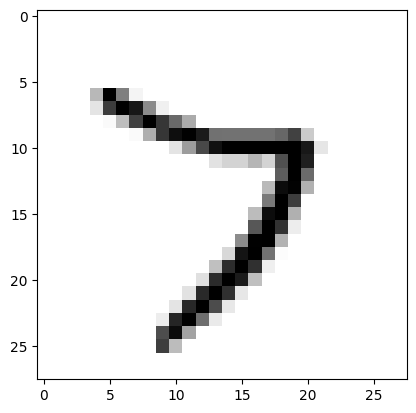

In [41]:
mlp.eval()              # turn the model to evaluate mode
index = 200
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
image = torch_X_test[index].float().unsqueeze(0)
true_label = y_test[index]
with torch.no_grad():     # does not calculate gradient
    class_index = mlp(image).argmax()   #gets the prediction for the image's class
plt.imshow(image.numpy().reshape(28,28,1), cmap='gray_r');
print(true_label)
print(class_index)

In [42]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

pred, labe = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(data.shape[0], -1)
        data = data.float()
        output = mlp(data)
        preds = output.argmax(dim=1)
        pred.extend(preds.numpy())
        labe.extend(target.numpy())

_, _, f1, _ = precision_recall_fscore_support(labe, pred, average='macro')
acc = accuracy_score(labe, pred)

print("F1:", f1); print("Accuracy:", acc)

F1: 0.9493582408360919
Accuracy: 0.9498412698412698


In [43]:
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([35700, 1, 28, 28])
torch.Size([6300, 1, 28, 28])


In [44]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([32, 10])


In [45]:
fit(cnn,train_loader)

Epoch : 0 [0/35700 (0%)]	Loss: 16.755548	 Accuracy:15.625%
Epoch : 0 [1600/35700 (4%)]	Loss: 2.030565	 Accuracy:16.054%
Epoch : 0 [3200/35700 (9%)]	Loss: 1.228704	 Accuracy:30.941%
Epoch : 0 [4800/35700 (13%)]	Loss: 0.874715	 Accuracy:42.984%
Epoch : 0 [6400/35700 (18%)]	Loss: 0.388923	 Accuracy:51.601%
Epoch : 0 [8000/35700 (22%)]	Loss: 0.677385	 Accuracy:57.620%
Epoch : 0 [9600/35700 (27%)]	Loss: 0.639983	 Accuracy:61.898%
Epoch : 0 [11200/35700 (31%)]	Loss: 0.540811	 Accuracy:65.135%
Epoch : 0 [12800/35700 (36%)]	Loss: 0.325609	 Accuracy:67.729%
Epoch : 0 [14400/35700 (40%)]	Loss: 0.687781	 Accuracy:69.782%
Epoch : 0 [16000/35700 (45%)]	Loss: 0.257438	 Accuracy:71.563%
Epoch : 0 [17600/35700 (49%)]	Loss: 0.160791	 Accuracy:73.162%
Epoch : 0 [19200/35700 (54%)]	Loss: 0.244723	 Accuracy:74.444%
Epoch : 0 [20800/35700 (58%)]	Loss: 0.194989	 Accuracy:75.586%
Epoch : 0 [22400/35700 (63%)]	Loss: 0.198802	 Accuracy:76.614%
Epoch : 0 [24000/35700 (67%)]	Loss: 0.336842	 Accuracy:77.451%
Epoc

3
tensor(3)


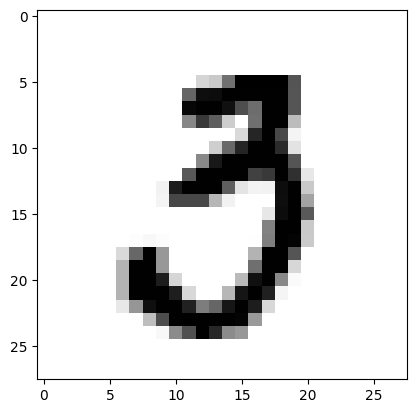

In [46]:
cnn.eval()              # turn the model to evaluate mode
index = 100
torch_X_test = torch_X_test.view(-1,1,28,28).float().type(torch.LongTensor)
image = torch_X_test[index].float().unsqueeze(0)
true_label = y_test[index]
with torch.no_grad():     # does not calculate gradient
    class_index = cnn(image).argmax()   #gets the prediction for the image's class
plt.imshow(image.numpy().reshape(28,28,1), cmap='gray_r');
print(true_label)
print(class_index)

In [47]:
pred, labe = [], []
with torch.no_grad():
    for data, target in test_loader:
        output = cnn(data)
        preds = output.argmax(dim=1)
        pred.extend(preds.numpy())
        labe.extend(target.numpy())
        
_, _, f1, _ = precision_recall_fscore_support(labe, pred, average='macro')
accuracy = accuracy_score(labe, pred)

print("F1 Score:", f1); print("Accuracy:", accuracy)

F1 Score: 0.9798854624044069
Accuracy: 0.98


Describe the performance of the MLP and CNN models? Performance can include training time, accuracy, etc.

Loss: The MLP has a significantly less loss, indicating a better fit to the training set and fewer prediction mistakes.

Accuracy: MLP performs better on test data, although MLP performs better on training data. This shows that, in comparison to the MLP, the CNN is more effective in generalizing to new data.

F1 Score: On test data, the CNN consistently beats the MLP on F1 Score, suggesting that it could be more dependable for tasks requiring equal performance across classes.

Training Time: The MLP takes only 2.9 seconds, but the CNN takes 1 minute and 58 seconds. This is a substantial difference in efficiency.

Extra Credit: Describe the below code and the output

Init idx: 3
13.823554992675781 -1.0728830375228426e-06 -13.823555946350098

Job done, breaking
tensor([-2.1452, -2.1217, -2.2663, -2.3947, -2.4194, -2.3471, -2.5375, -2.3667,
        -2.1326, -2.3835])


1

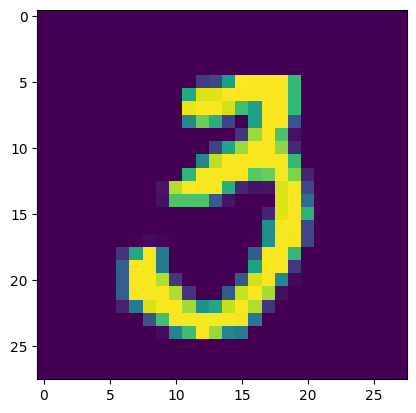

In [48]:
model = cnn
#torch_X_test = torch_X_test.view(-1,1,28,28).float().type(torch.LongTensor)

x = torch_X_test[index].float().clone()
x.requires_grad_(True)

with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    IMX = torch.argmax(logits)
print("Init idx:",IMX.item())
    
lr=.01

while True:
    logits = model(x.unsqueeze(0)).squeeze()
    imx = torch.argmax(logits)
    
    if imx!=IMX: 
        print("Job done, breaking")
        break
    
    y = logits.clone()
    y[imx] = -99
    loss = logits.max() - y.max() 
    loss.backward()
    
    x.data.sub_(lr*x.grad.data)
    print(loss.item(),logits.max().item(), y.max().item() )
    print()
    x.grad.data.zero_()
    x.data.sub_(x.data.min())
    x.data.mul_(1/x.data.max())

with torch.no_grad():
    print(model(x.unsqueeze(0)).squeeze())

plt.imshow(x.detach().cpu().numpy().transpose(1,2,0).reshape(28,28));torch.argmax(model(x.unsqueeze(0))).item()

The code applies modifications to an image, which a convolutional neural network (CNN) initially recognizes as class "3". The goal is to subtly alter the image such that, despite minimal visual changes apparent to the human eye, the CNN's prediction shifts. After the adjustments, the network misclassifies the image as class "1". 

This technique illustrates how small, calculated changes to an image can deceive a neural network into making incorrect predictions, highlighting potential vulnerabilities in machine learning models.

Output-


As modifications are applied, a loop tracks these changes by printing out the loss, which indicates a decreasing confidence in the original class prediction. 

Once the modifications are successful in shifting the predicted class from 0 to another, a message stating "Job done, breaking" is displayed, signaling the end of the process. 

Subsequently, the final tensor is examined to reveal the logits for each class following the modification. Lastly, the modified image is displayed using plt.imshow, and the new predicted class, now class 8, is confirmed through a call to torch.argmax.